Training Flower Dataset
1) Load and normalize the flowers training and test dataset
2) Define a CNN
3) Define a loss function
4) Train the network on training data
5) Test the network on test data

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import scipy.io
import os

In [89]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [90]:
#Load the labels of the flower (102)
labels = scipy.io.loadmat('/content/drive/MyDrive/imagelabels.mat')['labels'].squeeze() - 1  # Convert to zero-based indexing
#Load the id of the images for train and test
splits = scipy.io.loadmat('/content/drive/MyDrive/setid.mat')

# Get the train, test, and validation indices
train_ids = splits['trnid'][0] #Training set ids
test_ids = splits['tstid'][0]  #Test set ids
valid_ids = splits['valid'][0]  #Validation set ids

In [91]:
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms

class FlowerDataset(Dataset):
    def __init__(self, labels, image_dir, image_ids, transform=None):
        super().__init__()
        self.labels = labels
        self.image_dir = image_dir
        self.image_ids = image_ids
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_path = os.path.join(self.image_dir, f"image_{img_id:05d}.jpg")  # Aggiungi "image_" e padding a 5 cifre
        image = Image.open(img_path).convert("RGB")
        label = self.labels[img_id - 1]

        if self.transform:
            image = self.transform(image)
        return image, label

In [92]:
from torch.utils.data import DataLoader
# Define transformations for training and testing
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

data_dir = '/content/drive/MyDrive/102flowers/jpg'
# Create datasets
train_dataset = FlowerDataset(labels, data_dir, train_ids, transform=transform_train)
test_dataset = FlowerDataset(labels, data_dir, test_ids, transform=transform_test)
valid_dataset = FlowerDataset(labels, data_dir, valid_ids, transform=transform_test)

batch_size = 16
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

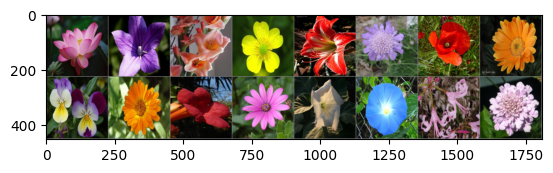

77 18 42 47 90 21 25 40 51 4 100 65 74 75 36 21


In [93]:
#Visualize some images
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    image = img / 2 + 0.5
    npimg = image.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    plt.imshow(npimg)
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{labels[j]}' for j in range(batch_size)))

In [94]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 102) # 102 classes for flowers

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = CNN()

In [95]:
from torch import optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9)

In [99]:
epochs = 20
model = net.cuda() if torch.cuda.is_available() else net

for epoch in range(epochs):
  total_loss, total_samples = 0.0, 0
  for i, data in enumerate(train_loader, 0):
    inputs, labels = data
    inputs, labels = inputs.cuda(), labels.cuda()
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    total_loss += loss.item() * inputs.size(0)
    total_samples += inputs.size(0)


    print(f'Average loss for epoch {epoch+1} batch {i+1}: {1.0*total_loss/float(total_samples):.6f}')
print('Training finished')




Average loss for epoch 1 batch 1: 1.984537
Average loss for epoch 1 batch 2: 2.251410
Average loss for epoch 1 batch 3: 2.190988
Average loss for epoch 1 batch 4: 2.141870
Average loss for epoch 1 batch 5: 2.245206
Average loss for epoch 1 batch 6: 2.297804
Average loss for epoch 1 batch 7: 2.296445
Average loss for epoch 1 batch 8: 2.259246
Average loss for epoch 1 batch 9: 2.249116
Average loss for epoch 1 batch 10: 2.210216
Average loss for epoch 1 batch 11: 2.235886
Average loss for epoch 1 batch 12: 2.240446
Average loss for epoch 1 batch 13: 2.248472
Average loss for epoch 1 batch 14: 2.230364
Average loss for epoch 1 batch 15: 2.212727
Average loss for epoch 1 batch 16: 2.220256
Average loss for epoch 1 batch 17: 2.246803
Average loss for epoch 1 batch 18: 2.246888
Average loss for epoch 1 batch 19: 2.219326
Average loss for epoch 1 batch 20: 2.225420
Average loss for epoch 1 batch 21: 2.211456
Average loss for epoch 1 batch 22: 2.206163
Average loss for epoch 1 batch 23: 2.2039

In [101]:
PATH = '/content/drive/MyDrive/model.pth'

torch.save(model.state_dict(), PATH)

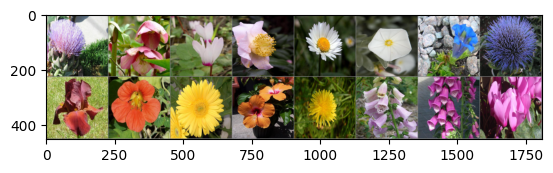

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False,  True, False,  True, False], device='cuda:0')	


In [100]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
images, labels = images.cuda(), labels.cuda()

outputs = model(images)
_, predicted = torch.max(outputs, 1)
print(''.join(f'{predicted==labels}\t'))

In [102]:
correct_pred = {classname:0 for classname in range(102)}
total_pred = {classname:0 for classname in range(102)}

corrects = 0
total = 0

with torch.no_grad():
    for batch in test_loader:
        images, labels = batch
        images, labels = images.cuda(), labels.cuda()

        total += images.size(0)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        for (label, pred) in zip(labels, predicted):
            total_pred[label.item()] += 1
            if (label == pred):
                correct_pred[label.item()] += 1
                corrects +=1

print(f'Total accuracy: {100*(1.0*corrects/float(total)):.2f}%')

for classname in correct_pred.keys():
    print(f'Accuracy for class {classname}: {100*(1.0*correct_pred[classname]/float(total_pred[classname])):.2f}%')

Total accuracy: 15.53%
Accuracy for class 0: 20.00%
Accuracy for class 1: 60.00%
Accuracy for class 2: 5.00%
Accuracy for class 3: 8.33%
Accuracy for class 4: 24.44%
Accuracy for class 5: 20.00%
Accuracy for class 6: 20.00%
Accuracy for class 7: 26.15%
Accuracy for class 8: 11.54%
Accuracy for class 9: 20.00%
Accuracy for class 10: 1.49%
Accuracy for class 11: 32.84%
Accuracy for class 12: 13.79%
Accuracy for class 13: 7.14%
Accuracy for class 14: 24.14%
Accuracy for class 15: 9.52%
Accuracy for class 16: 27.69%
Accuracy for class 17: 8.06%
Accuracy for class 18: 6.90%
Accuracy for class 19: 13.89%
Accuracy for class 20: 20.00%
Accuracy for class 21: 7.69%
Accuracy for class 22: 7.04%
Accuracy for class 23: 18.18%
Accuracy for class 24: 9.52%
Accuracy for class 25: 14.29%
Accuracy for class 26: 30.00%
Accuracy for class 27: 6.52%
Accuracy for class 28: 1.72%
Accuracy for class 29: 20.00%
Accuracy for class 30: 6.25%
Accuracy for class 31: 8.00%
Accuracy for class 32: 7.69%
Accuracy for